Andrea Di Domenico - S287639

TSP Problem - Evolutionary algorithm

In [12]:
from math import sqrt
from typing import Any
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random 
import operator 
import pandas as pd

In [13]:
class Tsp:
    def __init__(self, num_cities: int, seed: Any = None) -> None:
        if seed is None:
            seed = num_cities
        self._num_cities = num_cities
        self._graph = nx.DiGraph()
        np.random.seed(seed)
        for c in range(num_cities):
            self._graph.add_node(c, pos=(np.random.random(), np.random.random()))

    def distance(self, n1, n2) -> int:
        pos1 = self._graph.nodes[n1]['pos']
        pos2 = self._graph.nodes[n2]['pos']
        return round(1_000_000 / self._num_cities * sqrt((pos1[0] - pos2[0])**2 +
                                                         (pos1[1] - pos2[1])**2))

    def evaluate_solution(self, solution: np.array) -> float:
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return total_cost

    def fitness(self, solution: np.array) -> float:
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return 1/total_cost
    
    def plot(self, path: np.array = None) -> None:
        if path is not None:
            self._graph.remove_edges_from(list(self._graph.edges))
            tmp = path.tolist() + [path[0]]
            for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
                self._graph.add_edge(n1, n2)
        plt.figure(figsize=(12, 5))
        nx.draw(self._graph,
                pos=nx.get_node_attributes(self._graph, 'pos'),
                with_labels=True,
                node_color='pink')
        if path is not None:
            plt.title(f"Current path: {self.evaluate_solution(path):,}")
        plt.show()

    @property
    def graph(self) -> nx.digraph:
        return self._graph

In [14]:
NUM_CITIES = 23
problem = Tsp(NUM_CITIES)

In [15]:
def tweak(solution: np.array, *, pm: float = 1/NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    p = None
    while p is None or p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        temp = new_solution[i1]
        new_solution[i1] = new_solution[i2]
        new_solution[i2] = temp
        p = np.random.random()
    return new_solution

In [16]:
#create an individual = one random solution
def createRoute(n_cities):
    route = np.array(range(n_cities))
    np.random.shuffle(route)     #randomly select a route that satisfy the constarints
    return route

In [17]:
#create a population = popSize random solution
def initialPopulation(popSize, prob):
    population = []     #create popSize individual (route)

    for i in range(0, popSize):
        population.append(createRoute(prob._num_cities))
    return population

In [18]:
#determine fitness and rank the solution
def rankRoutes(prob, population):
    fitnessResults = {}             #fitness = 1/route_Distance -> maximize fitness
    for i in range(0,len(population)):
        fitnessResults[i] = prob.fitness(np.array(population[i]))
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)     #ordered list

In [19]:
def selection(popRanked, eliteSize):        #roulette wheel selection
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()        #relative fitness weigh
    
    for i in range(0, eliteSize):           #elitism, we carry over the next generation the 'best' individuals
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def matingPool(population, selectionResults):       #extracting the selected individuals from our population
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [20]:
def breed(parent1, parent2):    #crossover (ordered)
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    for i in range(startGene, endGene):
        childP1.append(parent1[i])
    
    #not duplicate gene
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):        #elitism
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [21]:
def mutate(individual, mutationRate):           #swap mutation   
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [22]:
def nextGeneration(prob, currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(prob, currentGen)                          #rank the intividual in the current population
    selectionResults = selection(popRanked, eliteSize)          #determine the potential parent
    matingpool = matingPool(currentGen, selectionResults)       
    children = breedPopulation(matingpool, eliteSize)           #create the new population
    nextGeneration = mutatePopulation(children, mutationRate)   #applying mutation on ther new population
    return nextGeneration

In [23]:
def geneticAlgorithm(prob, popSize, eliteSize, mutationRate, generations):
    prob.plot(createRoute(prob._num_cities))
    pop = initialPopulation(popSize, prob)
    for i in range(0, generations):
        pop = nextGeneration(prob, pop, eliteSize, mutationRate)
    bestRouteIndex = rankRoutes(prob, pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

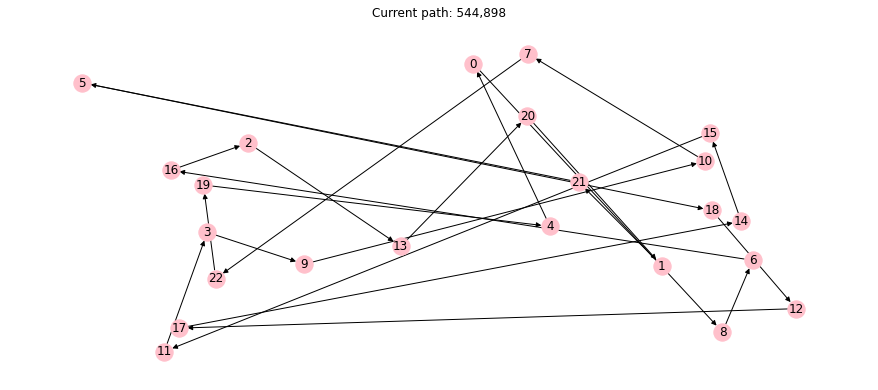

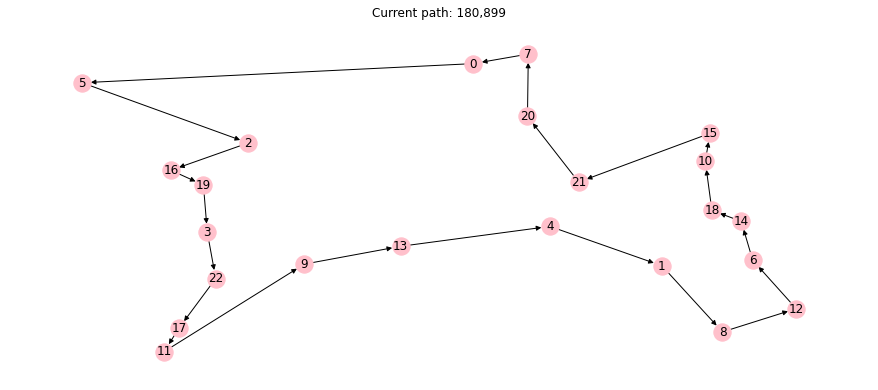

In [26]:
best_solution = geneticAlgorithm(prob=problem, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
problem.plot(np.array(best_solution))

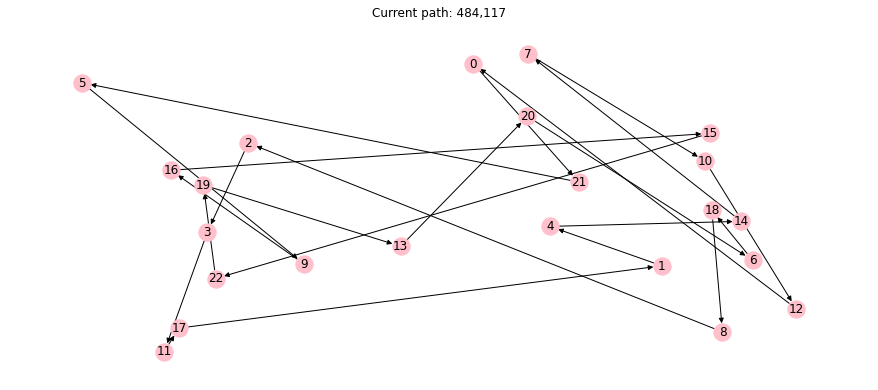

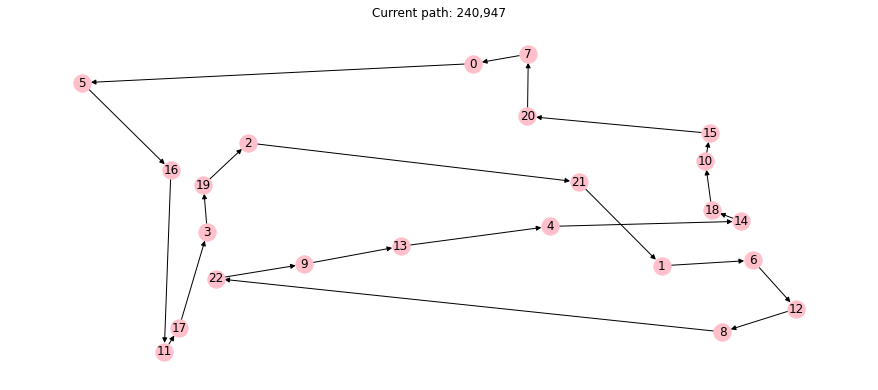

In [25]:
STEADY_STATE = 1000

solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
solution_cost = problem.evaluate_solution(solution)
problem.plot(solution)

history = [(0, solution_cost)]
steady_state = 0
step = 0
while steady_state < STEADY_STATE:
    step += 1
    steady_state += 1
    new_solution = tweak(solution, pm=.5)
    new_solution_cost = problem.evaluate_solution(new_solution)
    if new_solution_cost < solution_cost:
        solution = new_solution
        solution_cost = new_solution_cost
        history.append((step, solution_cost))
        steady_state = 0
problem.plot(solution)